# Look at all user activity 

|author|contestID|id|language|memoryBytes|participantType|passedTestCount|points|problem_index|problem_name|problem_tags|relativeTimeSeconds|startTimeSeconds|testset|timeMilliseconds|verdict
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
0|yj12|672|17895187|GNU C++|6246400|PRACTICE|60|2000|D|Robin Hood|[binary search, greedy]|2147483647|1462984500|TESTS|187|OK
1|yj12|672|17895170|GNU C++|6246400|PRACTICE|60|2000|D|Robin Hood|[binary search, greedy]|2147483647|1462984500|TESTS|233|OK


In [86]:
%matplotlib inline
%load_ext rpy2.ipython

import requests
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [87]:
handle = 'yj12'
maxcount = '100000000'
url = 'http://codeforces.com/api/user.status?handle=' + handle + '&from=1&count=' + maxcount

r = requests.get(url).json()['result']

In [88]:
arr = []
keys = ['testset', 'passedTestCount', 'author', 'relativeTimeSeconds', 
        'language', 'memoryBytes', 'timeMilliseconds', 'problem_name', 'problem_index',
        'problem_tags', 'points', 'contestID', 'verdict', 'id', 'participantType', 'startTimeSeconds']

for rr in r:
#    try:
    temp = dict.fromkeys(keys)
    temp['author'] = rr['author']['members'][0]['handle']
    temp['startTimeSeconds'] = rr['creationTimeSeconds']
    if 'startTimeSeconds' not in rr['author']:
        temp['participantType'] = 'GYM'
    else:
    #    temp['startTimeSeconds'] = rr['author']['startTimeSeconds']
        temp['participantType'] = rr['author']['participantType']
    temp['id'] = rr['id']
    temp['verdict'] = rr['verdict']
    temp['contestID'] = rr['contestId']
    if 'points' not in rr['problem']:
        temp['points'] = 0
    else:
        temp['points'] = rr['problem']['points']
    temp['problem_tags'] = rr['problem']['tags']
    temp['problem_index'] = rr['problem']['index']
    temp['problem_name'] = rr['problem']['name']
    temp['timeMilliseconds'] = rr['timeConsumedMillis']
    temp['memoryBytes'] = rr['memoryConsumedBytes']
    temp['language'] = rr['programmingLanguage']
    temp['relativeTimeSeconds'] = rr['relativeTimeSeconds']
    temp['passedTestCount'] = rr['passedTestCount']
    temp['testset'] = rr['testset']

    arr.append(temp)
#    except:
#        print "----------------------"
#        for key, val in rr.iteritems():
#            print key, ":", val
    
hact = pd.DataFrame.from_dict(arr)

In [89]:
df_problems = pd.DataFrame.from_csv('problem_ratings.csv', index_col=None)
df_problems.index = [df_problems['contestID'], df_problems['problemID']]


# Rating History

In [90]:
url = 'http://codeforces.com/api/user.rating?handle=' + handle

r = requests.get(url).json()['result']
rating_history = pd.DataFrame.from_dict(r)

# Visualizations

In [91]:
#df_success = hact.loc[hact.verdict!='OK']
df_success = hact
df_success.index = [ df_success.contestID, df_success.problem_index ]

problem_ratings = []
keyerrors = []
for cid, pid in zip(df_success.contestID, df_success.problem_index):
    try:
        problem_ratings.append(df_problems.loc[cid,pid].problemRating)
    except KeyError:
        keyerrors.append([cid, pid])
        problem_ratings.append(-1)

df_success.loc[:,'problem_rating'] = problem_ratings

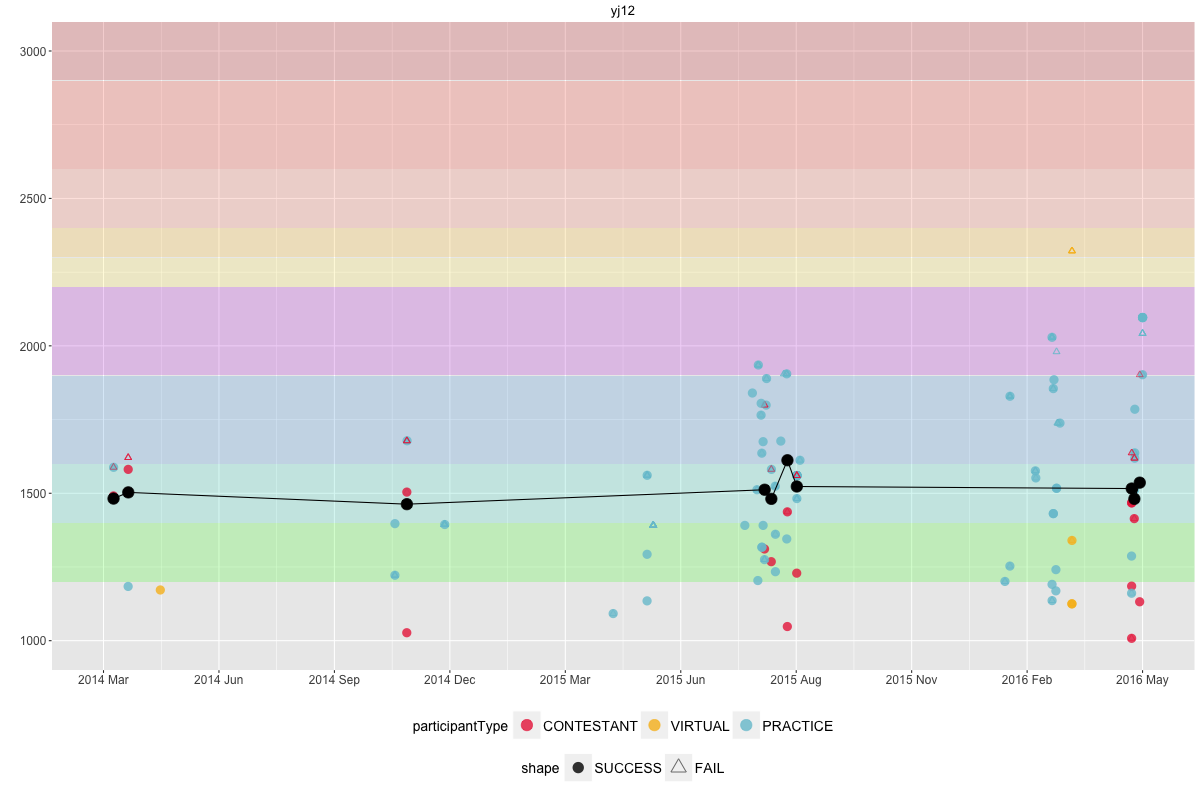

In [92]:
%%R -i df_success -w 1200 -h 800 -u px -i rating_history -i handle
library(ggplot2)
#library(plotly)

blank_theme <- theme(
        #axis.line.y = element_blank(),
        #axis.line.x = element_blank(),
        #panel.grid.major = element_blank(),
        #panel.grid.minor = element_blank(),
        #panel.border = element_blank(),
        #panel.background = element_blank(),
        #axis.ticks.y = element_blank(),
        axis.text.y = element_text(size = 12),
        axis.text.x = element_text(size = 12),
        #axis.title.y = element_blank(),
        legend.position = 'bottom',
        legend.text = element_text(size=14),
        legend.title = element_text(size=14),
        legend.key.size = unit(1, "cm")) 

df_success <- as.data.frame(df_success)
df_success$size <- (df_success$verdict == 'OK') + 1
df_success$shape <-'SUCCESS' 
df_success$shape[df_success$verdict != 'OK'] <-'FAIL' 
df_success$shape <- factor(df_success$shape, levels=c('SUCCESS', 'FAIL'))
df_success$participantType <- factor(df_success$participantType, 
                                     levels=c('CONTESTANT', 'VIRTUAL', 'PRACTICE', 'GYM', 'OUT_OF_COMPETITION'))
df_success <- as.data.frame(df_success)
df_success$date <- as.POSIXct.numeric(df_success$startTimeSeconds,origin="1970-01-01")

df_rating <- as.data.frame(rating_history)
df_rating$date <- as.Date(as.POSIXct(df_rating$ratingUpdateTimeSeconds, origin="1970-01-01"),
                                             origin="1970-01-01")
color_scale <- c('CONTESTANT' = '#EA2E49',
                 'VIRTUAL' = '#F7BC20',
                 'PRACTICE' = '#77C4D3',
                 'GYM' = '#EBC4FF',
                 'OUT_OF_COMPETITION' = '#333745')

xaxis_breaks <- seq(min(df_success$date), max(df_success$date), length.out = 10)
xaxis_labs <- format(xaxis_breaks, "%Y %b")
#print(as.Date.numeric(df_success$startTimeSeconds, origin="1970-01-01"))
bgalpha = .2

c <- ggplot(df_success)
c <- c + 
    annotate("rect", ymin=1200, ymax=1399, xmin=-Inf, xmax=Inf, color=NA, fill='green', alpha=bgalpha) +
    annotate("rect", ymin=1400, ymax=1599, xmin=-Inf, xmax=Inf, color=NA, fill='#30DBCA', alpha=bgalpha) +
    annotate("rect", ymin=1600, ymax=1899, xmin=-Inf, xmax=Inf, color=NA, fill='#3094DB', alpha=bgalpha) +
    annotate("rect", ymin=1900, ymax=2199, xmin=-Inf, xmax=Inf, color=NA, fill='#B930DB', alpha=bgalpha) +
    annotate("rect", ymin=2200, ymax=2299, xmin=-Inf, xmax=Inf, color=NA, fill='#FFEA4D', alpha=bgalpha) +
    annotate("rect", ymin=2300, ymax=2399, xmin=-Inf, xmax=Inf, color=NA, fill='#FFBF00', alpha=bgalpha) +
    annotate("rect", ymin=2400, ymax=2599, xmin=-Inf, xmax=Inf, color=NA, fill='#FF7E61', alpha=bgalpha) +
    annotate("rect", ymin=2600, ymax=2899, xmin=-Inf, xmax=Inf, color=NA, fill='#FF4117', alpha=bgalpha) +
    annotate("rect", ymin=2900, ymax=Inf, xmin=-Inf, xmax=Inf, color=NA, fill='#CC0000', alpha=bgalpha) +
    geom_point(data = df_success,
               aes(x=startTimeSeconds, y = problem_rating, 
               color=participantType, size=size, shape=shape, fill=participantType), alpha=.8) + 
    geom_point(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = 5) + 
    geom_line(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = .5) + 
    #facet_wrap(~participantType, ncol=1) +
    #facet_wrap(~verdict, ncol=1) +
    scale_y_continuous(limits=c(1000, 3000)) + 
    scale_x_continuous(breaks=as.numeric(xaxis_breaks), labels=xaxis_labs) + 
#    scale_x_date(df_rating$ratingUpdateTimeSeconds)+
    blank_theme +
    guides(size = FALSE) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    guides(shape = guide_legend(override.aes = list(size=5))) +
    scale_color_manual(values = color_scale) +
    scale_size(range=c(2,4)) +
    scale_shape_manual(values=c('SUCCESS' = 16, "FAIL" = 2)) + 
    labs(x = '', y='', title=handle)
print(c)
#as.Date((df_success$startTimeSeconds)/1000 , origin="1970-01-01")

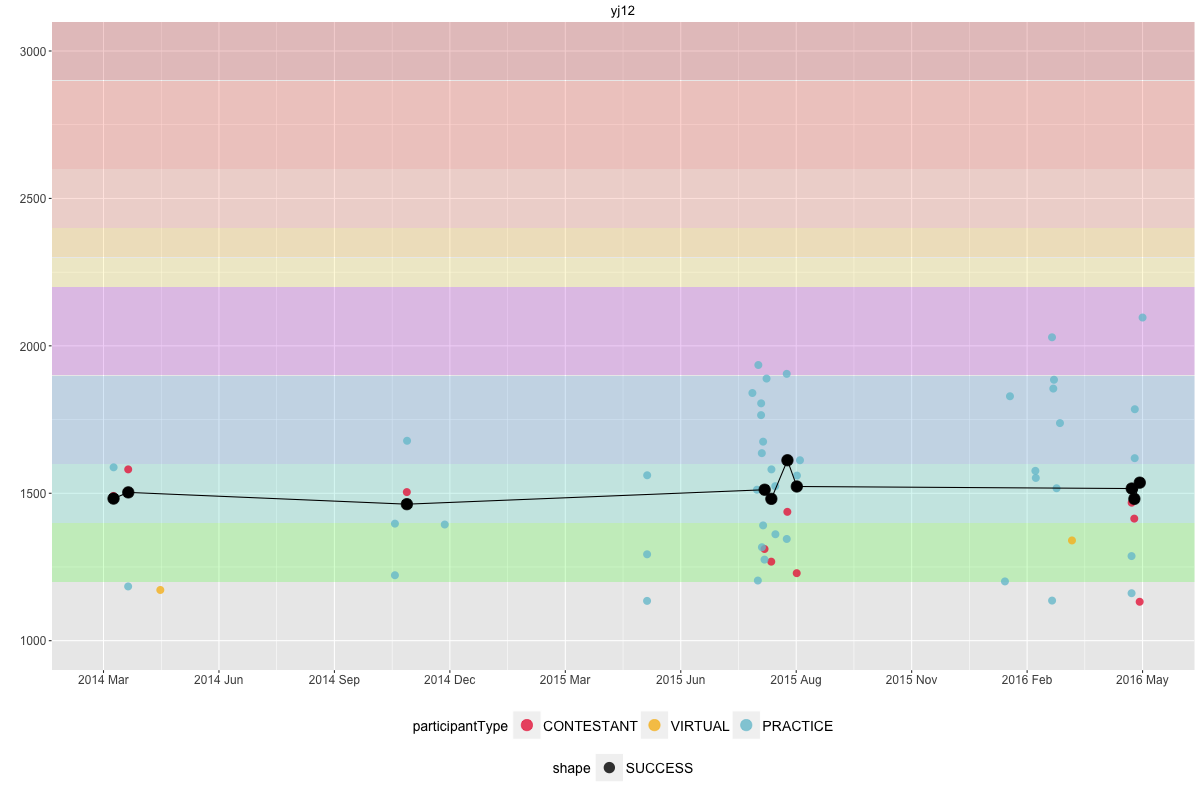

In [93]:
%%R -w 1200 -h 800 -u px
#names(df_success)
maxcontest <- tapply(1:nrow(df_success), df_success$contestID, function(idx){
    df <- df_success[idx,c('startTimeSeconds', 'verdict', 'problem_rating', 'participantType', 'size', 'shape')]
    df <- df[df$verdict == 'OK' & df$participantType=='CONTESTANT',]
    df[df$problem_rating == max(df$problem_rating),][1,]
})
maxcontest <- do.call(rbind, maxcontest)
maxpractice <- tapply(1:nrow(df_success), df_success$contestID, function(idx){
    df <- df_success[idx,c('startTimeSeconds', 'verdict', 'problem_rating', 'participantType', 'size', 'shape')]
    df <- df[df$verdict == 'OK' & df$participantType!='CONTESTANT',]
    df[df$problem_rating == max(df$problem_rating),][1,]
})
maxpractice <- do.call(rbind, maxpractice)
maxcontest <- rbind(maxcontest, maxpractice)

c <- ggplot(df_success)
c <- c + 
    annotate("rect", ymin=1200, ymax=1399, xmin=-Inf, xmax=Inf, color=NA, fill='green', alpha=bgalpha) +
    annotate("rect", ymin=1400, ymax=1599, xmin=-Inf, xmax=Inf, color=NA, fill='#30DBCA', alpha=bgalpha) +
    annotate("rect", ymin=1600, ymax=1899, xmin=-Inf, xmax=Inf, color=NA, fill='#3094DB', alpha=bgalpha) +
    annotate("rect", ymin=1900, ymax=2199, xmin=-Inf, xmax=Inf, color=NA, fill='#B930DB', alpha=bgalpha) +
    annotate("rect", ymin=2200, ymax=2299, xmin=-Inf, xmax=Inf, color=NA, fill='#FFEA4D', alpha=bgalpha) +
    annotate("rect", ymin=2300, ymax=2399, xmin=-Inf, xmax=Inf, color=NA, fill='#FFBF00', alpha=bgalpha) +
    annotate("rect", ymin=2400, ymax=2599, xmin=-Inf, xmax=Inf, color=NA, fill='#FF7E61', alpha=bgalpha) +
    annotate("rect", ymin=2600, ymax=2899, xmin=-Inf, xmax=Inf, color=NA, fill='#FF4117', alpha=bgalpha) +
    annotate("rect", ymin=2900, ymax=Inf, xmin=-Inf, xmax=Inf, color=NA, fill='#CC0000', alpha=bgalpha) +
    geom_point(data = maxcontest,
               aes(x=startTimeSeconds, y = problem_rating, 
               color=participantType, size=size, shape=shape, fill=participantType), alpha=.8) + 
    geom_point(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = 5) + 
    geom_line(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = .5) + 
    #facet_wrap(~participantType, ncol=1) +
    #facet_wrap(~verdict, ncol=1) +
    scale_y_continuous(limits=c(1000, 3000)) + 
    scale_x_continuous(breaks=as.numeric(xaxis_breaks), labels=xaxis_labs) + 
#    scale_x_date(df_rating$ratingUpdateTimeSeconds)+
    blank_theme +
    guides(size = FALSE) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    guides(shape = guide_legend(override.aes = list(size=5))) +
    scale_color_manual(values = color_scale) +
    scale_size(range=c(2,4)) +
    scale_shape_manual(values=c('SUCCESS' = 16, "FAIL" = 2)) + 
    labs(x = '', y='', title=handle)
print(c)
#as.Date((df_success$startTimeSeconds)/1000 , origin="1970-01-01")

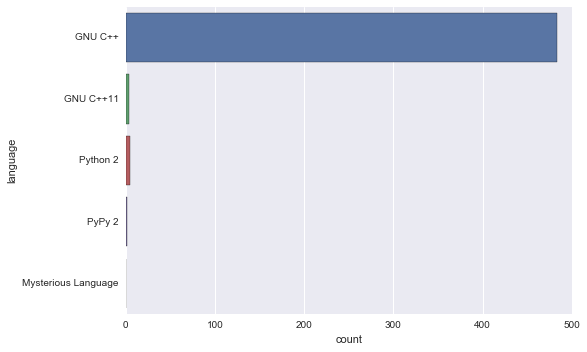

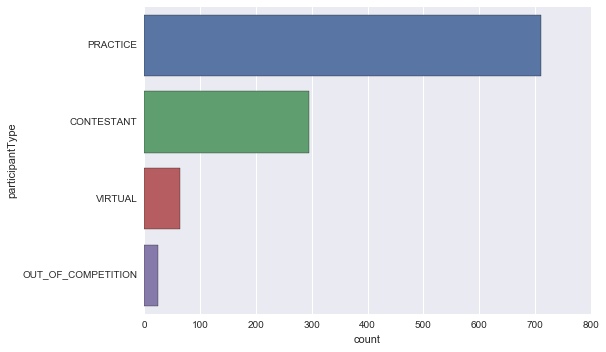

In [273]:
passidx = hact.verdict=='OK'
set(hact.participantType)
sns.set(rc={'figure.facecolor':'white'})
sns.countplot(y='language', data=hact.loc[hact['verdict']=='OK'])

plt.figure()
sns.countplot(y='participantType', data=hact)

In [274]:
hact.startTimeSeconds
years = []
for s in hact.startTimeSeconds:
    time = datetime.fromtimestamp(s)
    years.append(time.year)

hact['year'] = years
#datetime.fromtimestamp(hact.startTimeSeconds[0])
#hact['date'] = pd.to_datetime(hact.startTimeSeconds, unit='s')
#
##import matplotlib.dates as mdates
#
##ax.xaxis.set_major_locator(mdates.AutoDateLocator())
##ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

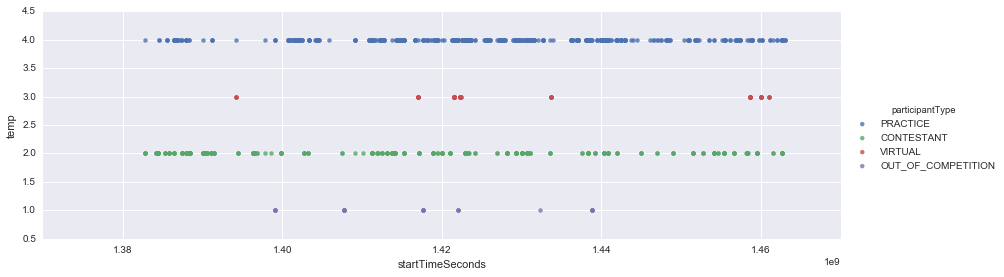

In [275]:
hact['temp'] = 1
hact.loc[hact.participantType=='CONTESTANT', 'temp'] = 2
hact.loc[hact.participantType=='VIRTUAL', 'temp'] = 3
hact.loc[hact.participantType=='PRACTICE', 'temp'] = 4
hact.loc[hact.participantType=='GYM', 'temp'] = 4
sns.lmplot(x='startTimeSeconds', y = 'temp', hue='participantType', data=hact, fit_reg=False, size=4, aspect=3)

In [276]:
hact.loc[hact.year==2010]

,,author,contestID,id,language,memoryBytes,participantType,passedTestCount,points,problem_index,problem_name,problem_tags,relativeTimeSeconds,startTimeSeconds,testset,timeMilliseconds,verdict,problem_rating,year,temp
contestID,problem_index,,,,,,,,,,,,,,,,,,,


NameError: name 'test' is not defined

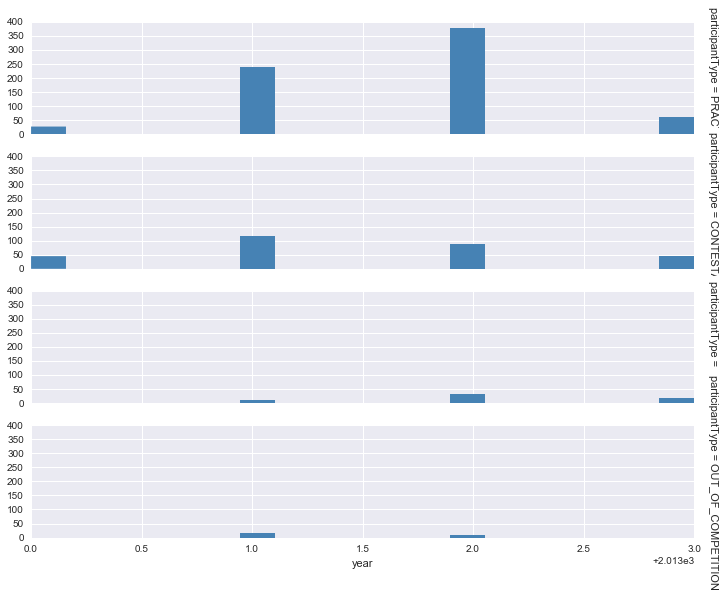

In [277]:
#f, ax = plt.subplots(figsize=(12, 7), facecolor='white')
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(rc={'figure.facecolor':'white'})
g = sns.FacetGrid(hact, row="participantType", margin_titles=True, size=2, aspect=5)
#bins = np.linspace(min(hact.startTimeSeconds), max(hact.startTimeSeconds), 20)
#g.map(plt.hist, "startTimeSeconds", color="steelblue", bins=bins, lw=0)
bins = np.linspace(min(hact.year), max(hact.year), 20)
g.map(plt.hist, "year", color="steelblue", bins=bins, lw=0)

#test = g.axes[0][0]
ticks = test.get_xticks()
print ticks
#
#ticlabs = []
#for tic in ticks:
#    ticlabs.append(str(datetime.fromtimestamp(tic))) 
#    
#test.set_xticklabels(ticlabs)
#ax = plt.gca()
#print ax.xaxis.get_ticklabels()
#fig = plt.gcf()
#fig.get_yticks()

In [ ]:
test = g.axes[0][0]
ticks = test.get_xticks()

ticlabs = []
for tic in ticks:
    print pd.to_datetime(tic, unit='s')
    ticlabs.append(str(datetime.fromtimestamp(tic))) 
    
test.set_xticklabels(ticlabs)
test

In [ ]:
df = pd.DataFrame(
    data=np.random.randn(90, 4),
    columns=pd.Series(list("ABCD"), name="walk"),
    index=pd.date_range("2015-01-01", "2015-03-31",
                        name="date"))
df = df.cumsum(axis=0).stack().reset_index(name="val")
def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
g = sns.FacetGrid(df, col="walk", col_wrap=2, size=3.5)
g = g.map_dataframe(dateplot, "date", "val")

In [ ]:
np.arange(1,5,1)